In [2]:
import pandas as pd
from get_SAB import *
import copy
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
import matplotlib

In [5]:

info2 = {}
maxSAB = 0.0
with open('leaprRun/ENDF_typical/tape24','r') as f:
    lines = [line for line in f.readlines() if line[71:75] == '7  4']

    nbeta  = getVal(lines[4],5,'int')
    nalpha = getVal(lines[6],5,'int')
    numAlphaLines = ceil(nalpha/3)
    lines = lines[6:]

    for ibeta in range(nbeta):
        offset = 2
        beta = getVal(lines[0],1)
        alphas, sab = [], []
        for i in range(numAlphaLines):
            for j in range(3):
                alphas.append(getVal(lines[offset+i],2*j  ))
                sabVal = getVal(lines[offset+i],2*j+1)
                #sabVal = np.log(sabVal) if sabVal > 1e-9 else -20
                sab.append(sabVal)
                if sab[-1] > maxSAB:
                    maxSAB = sab[-1]
        info2[beta]  = [val*np.exp(-beta*0.5) for val in sab]
        info2[-beta] = [val*np.exp( beta*0.5) for val in sab]
        #info2[beta]  = [val*np.exp(-beta) for val in sab]
        #info2[-beta] = [val*np.exp(0.0)   for val in sab]
        lines = lines[numAlphaLines+offset:]

    betas = (list(info2.keys()))
    betas.sort()


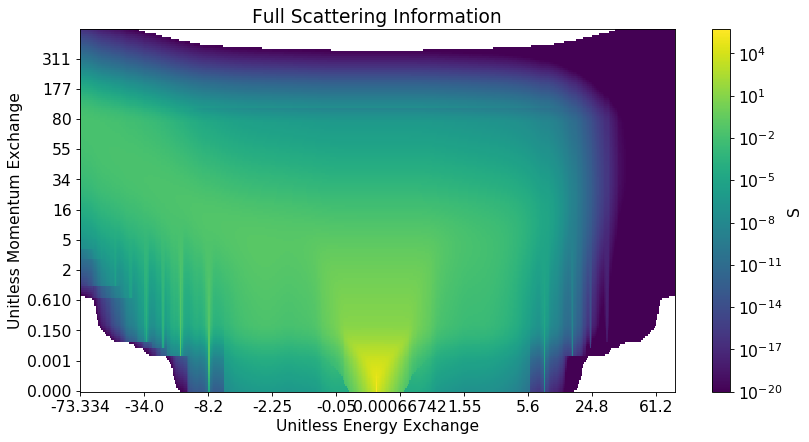

In [6]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 14})
df = pd.DataFrame(data=info2)
df = df.sort_index(ascending = True, axis = 1)

df2 = pd.DataFrame(data=info2, index=alphas,columns=betas)
df2 = df2.sort_index(ascending = True, axis = 1)




plt.pcolor(df, norm=LogNorm(vmin=1e-20, vmax=maxSAB))#, cmap='PuBu_r')
# plt.pcolor(df2, vmin=-20, vmax=13)#, cmap='PuBu_r')
plt.colorbar(label='S')
plt.yticks(np.arange(0.5, len(df2.index), 15), ['%.3f'%x if x < 1 else '%.0f'%x for x in df2.index[::15] ])
plt.xticks(np.arange(0.5, len(df2.columns), 50), df2.columns[::50])
plt.xlabel('Unitless Energy Exchange')
plt.ylabel('Unitless Momentum Exchange')
plt.title('Full Scattering Information')
plt.show()

In [7]:
def getMinMaxAlphaIndices(alphaMin,alphaMax,alphas):
    alphaMinIndex, alphaMaxIndex = 0,len(alphas)
    for i,alpha in enumerate(alphas):
        if alpha > alphaMin:
            alphaMinIndex = i
            break
    for i in range(len(alphas)-1):
        if alphas[i+1] > alphaMax:
            alphaMaxIndex = i
            break
    return alphaMinIndex,alphaMaxIndex

In [8]:
def getSVD(df,numSingularValues):
    U, sigma, V = np.linalg.svd(df)
    print('Total number of singular values: ',len(sigma))
    Unew = U[:,:numSingularValues]
    Vnew = V[:numSingularValues,:]
    sigvals = sigma[:numSingularValues]
    return Unew,sigvals,Vnew

In [9]:
E       =  1.0
kbT     =  0.025
betaMin = -E/kbT
betaMax =  20.0
A       =  1.0

In [10]:
def getBetaPDF_normal(df2,betas):
    eq14Good = []
    this_df = df2
    these_betas = [b for b in betas if b > betaMin and b < betaMax]
    for ibeta,beta in enumerate(these_betas):
        alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
        alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)
        df_subset = this_df[beta].loc[(this_df.index > alphaMin) & (this_df.index < alphaMax)]
        these_alphas = list(df_subset.index)
        eq14Good.append(np.trapz(df_subset,x=these_alphas))

    total = np.trapz(eq14Good,x=these_betas)

    return [val/total for val in eq14Good]


In [11]:
def getBetaPDF_SVD(Unew,sigvals,Vnew,betas,alphas,betaMin,betaMax):
    eq14 = []
    for ibeta,beta in enumerate(betas):
        if beta < betaMin or beta > betaMax: 
            continue

        alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
        alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)
        alphaMinIndex,alphaMaxIndex = getMinMaxAlphaIndices(alphaMin,alphaMax,alphas)
        U_times_Sigma = [Unew[i,:]*sigvals for i in range(alphaMinIndex,alphaMaxIndex+1)]

        sab_only_this_beta = [np.dot(U_times_Sigma_row,Vnew[:,ibeta]) for U_times_Sigma_row in U_times_Sigma]
        these_alphas = [a for a in alphas if a > alphaMin and a < alphaMax]
        eq14.append(np.trapz(sab_only_this_beta,x=these_alphas))

    these_betas = [b for b in betas if b > betaMin and b < betaMax]
    total = np.trapz(eq14,x=these_betas)
    return [val/total for val in eq14]


In [12]:
def getAlphaPDFNormal(df2,ibeta,betas):    
    beta = betas[ibeta]
    alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
    alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)
    df_subset    = df2[beta].loc[(df2.index > alphaMin) & (df2.index < alphaMax)]
    these_alphas = list(df_subset.index)
    denominator  = np.trapz(df_subset,x=these_alphas)
    eq15 = [df_subset[alpha]/denominator for alpha in these_alphas]
    return these_alphas,eq15

In [13]:
def getAlphaPDFSVD(Unew,sigvals,Vnew,betas,alphas,betaMin,betaMax):
    beta = betas[ibeta]
    alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
    alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)
    alphaMinIndex,alphaMaxIndex = getMinMaxAlphaIndices(alphaMin,alphaMax,alphas)

    U_times_Sigma = [Unew[i,:]*sigvals for i in range(alphaMinIndex,alphaMaxIndex+1)]
    these_alphas = [a for a in alphas if a > alphaMin and a < alphaMax]

    eq15 = [np.dot(U_times_Sigma_row,Vnew[:,ibeta]) for U_times_Sigma_row in U_times_Sigma]
    denominator  = np.trapz(eq15,x=these_alphas)
    return these_alphas,[val/denominator for val in eq15]

In [14]:
Unew,sigvals,Vnew = getSVD(df,40)

Total number of singular values:  180


Text(0.5, 1.0, 'S(a,b) Beta PDF [Eq. 14]')

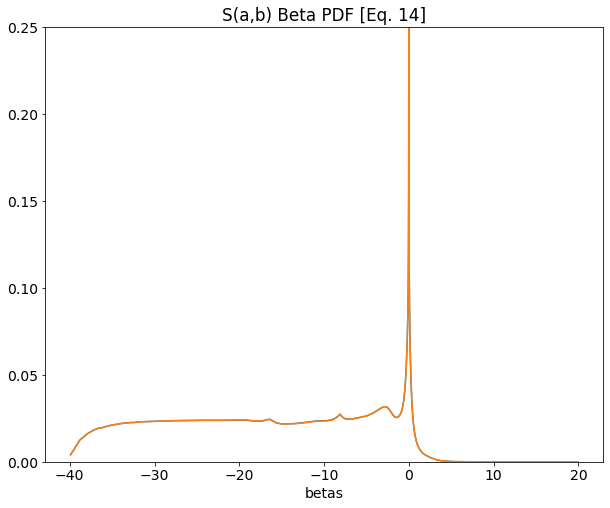

In [15]:
plt.figure(figsize=(10,8))

these_betas = [b for b in betas if b > betaMin and b < betaMax]

eq14Good = getBetaPDF_normal(df2,betas)
plt.plot(these_betas,eq14Good)

eq14SVD  = getBetaPDF_SVD(Unew,sigvals,Vnew,betas,alphas,betaMin,betaMax)
plt.plot(these_betas,eq14SVD)

plt.ylim([0,0.25])
plt.xlabel('betas')
plt.title('S(a,b) Beta PDF [Eq. 14]')

Text(0.5, 1.0, 'S(a,b) Beta CDF [Eq. 16]')

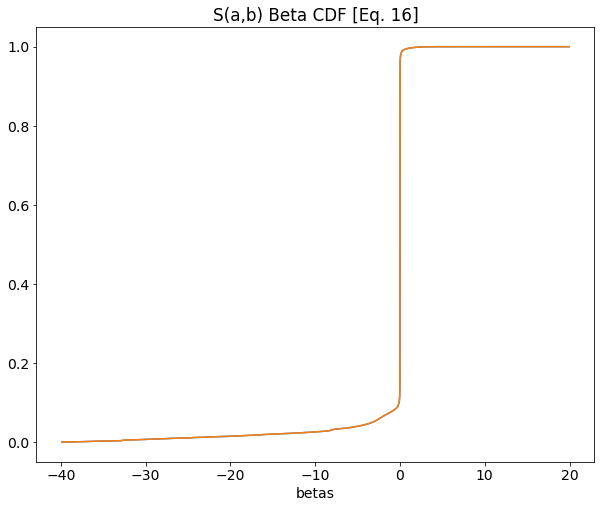

In [16]:
plt.figure(figsize=(10,8))

eq16Good = np.cumsum(eq14Good)
total = eq16Good[-1]
eq16Good = [val/total for val in eq16Good]
plt.plot(these_betas,eq16Good)

eq16SVD = np.cumsum(eq14SVD)
total = eq16SVD[-1]
eq16SVD = [val/total for val in eq16SVD]
plt.plot(these_betas,eq16SVD)

# plt.xlim([-40,-5])
# plt.ylim([-.02,.1])
plt.xlabel('betas')
plt.title('S(a,b) Beta CDF [Eq. 16]')

Text(0.5, 1.0, 'S(a,b) Alpha PDF [Eq. 15]')

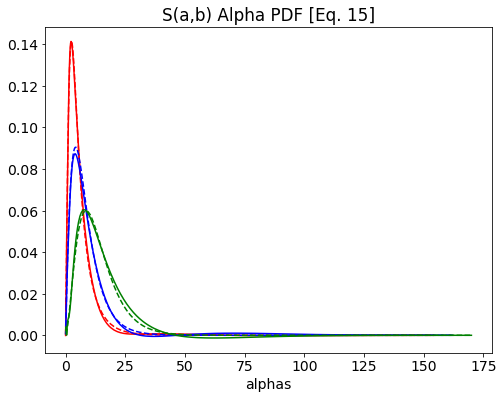

In [134]:
plt.figure(figsize=(8,6))
colors = ['r','b','g']
for i,ibeta in enumerate([280, 300, 350]):
    these_alphas,eq15Normal = getAlphaPDFNormal(df2,ibeta,betas)
    these_alphas,eq15SVD    = getAlphaPDFSVD(Unew,sigvals,Vnew,betas,alphas,betaMin,betaMax)
    plt.plot(these_alphas,eq15SVD,colors[i]+'-') 
    plt.plot(these_alphas,eq15Normal,colors[i]+'--') 
plt.xlabel('alphas')
plt.title('S(a,b) Alpha PDF [Eq. 15]')

In [27]:
from random import random



0.7200989602337625

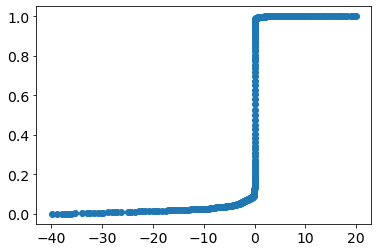

In [91]:
plt.plot(these_betas,eq16Good,'o-')

In [108]:
val_1 = random()
val_2 = random()
print(val_1,val_2)

0.21242990376175364 0.649744575256637


In [109]:
def binary_search(xVec, yVec, x, low=0, high=None): 
    if high == None: high = len(xVec)-1
    if x <= xVec[0] or x >= xVec[-1]: return None
    if high >= low: 
        mid = (high + low) // 2
        if   xVec[mid-1] <= x and xVec[mid] >= x: 
            m = (yVec[mid]-yVec[mid-1])/(xVec[mid]-xVec[mid-1])
            return mid,m*(x-xVec[mid-1]) + yVec[mid-1]
        elif xVec[mid] >  x: return binary_search(xVec, yVec, x, low, mid - 1) 
        else               : return binary_search(xVec, yVec, x, mid + 1, high) 
    else: 
        return None




In [110]:
# xVec = np.linspace(0,50,20)
# yVec = [x**3+2 for x in xVec]
# plt.plot(xVec,yVec,'o-')

# for x in np.linspace(0.1,49.5,200):
#     index, result = binary_search(xVec, yVec, x) 
#     plt.plot(x,result,'ro')


0.20517848949971573 0.9873028296675626
0.2 0.21242990376175364 0.225
0.9867205870626644 0.9873028296675626 0.9878916391803196


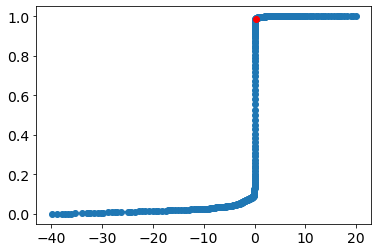

In [115]:
index, result = binary_search(these_betas,eq16Good,val_1)
plt.plot(these_betas,eq16Good,'o-')
plt.plot(val,result,'ro')
print(val,result)
print(these_betas[index-1],val_1,these_betas[index])
print(eq16Good[index-1],result,eq16Good[index])

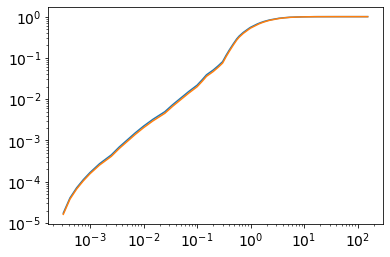

In [107]:
these_alphas,eq15Normal = getAlphaPDFNormal(df2,index-1,these_betas)
eq15Normal = np.cumsum(eq15Normal)
invVal = 1.0/eq15Normal[-1]
eq15Normal = [invVal*val for val in eq15Normal]
plt.plot(these_alphas,eq15Normal)

these_alphas,eq15Normal = getAlphaPDFNormal(df2,index,these_betas)
eq15Normal = np.cumsum(eq15Normal)
invVal = 1.0/eq15Normal[-1]
eq15Normal = [invVal*val for val in eq15Normal]
plt.plot(these_alphas,eq15Normal)


In [19]:
# plt.figure(figsize=(10,8))

# for i,ibeta in enumerate([280, 300, 350]):
#     these_alphas,eq15Normal = getAlphaPDFNormal(df2,ibeta,betas)
#     these_alphas,eq15SVD    = getAlphaPDFSVD(Unew,sigvals,Vnew,betas,alphas,betaMin,betaMax)
#     CDF_alpha_Normal = np.cumsum(eq15Normal)
#     CDF_alpha_SVD    = np.cumsum(eq15SVD)
# eq16Good = np.cumsum(eq14Good)
# total = eq16Good[-1]
# eq16Good = [val/total for val in eq16Good]
# plt.plot(these_betas,eq16Good)

# eq16SVD = np.cumsum(eq14SVD)
# total = eq16SVD[-1]
# eq16SVD = [val/total for val in eq16SVD]
# plt.plot(these_betas,eq16SVD)

# plt.xlim([-20,20])
# plt.xlabel('betas')
# plt.title('S(a,b) Beta CDF [Eq. 16]')

In [25]:
# data = pd.DataFrame(columns=betas,index=alphas)
# for beta in betas:
#     data[beta] = 0.0

# maxVal = 0.0
# for ibeta in range(len(betas)):
#     beta = betas[ibeta]
#     alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
#     alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)
#     eq15 = []

#     df_subset    = df2[beta].loc[(df2.index > alphaMin) & (df2.index < alphaMax)]
#     these_alphas = list(df_subset.index)
#     denominator  = np.trapz(df_subset,x=these_alphas)

#     for alpha in these_alphas:
#         eq15.append(df_subset[alpha]/denominator)
#         data[beta].loc[alpha] = eq15[-1]
#         if maxVal < eq15[-1]:
#             maxVal = eq15[-1]

        

In [23]:
# # plt.pcolor(data)
# plt.pcolor(data, norm=LogNorm(vmin=1e-6, vmax=maxVal))
# plt.colorbar()

In [ ]:
#alpha x 30     30 x 30.   30 x #betas